In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from functools import partial, reduce
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.stats import wilcoxon, ttest_rel
from scipy.signal import savgol_filter
from numpy.fft import fft, ifft, fftfreq
from robust_pde_diff import DLrSR, RobustPCA, DLrSR_para
from para_UBIC import *
from best_subset import *
from solvel0 import solvel0

from findiff import FinDiff
from abess.linear import LinearRegression
from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.utils.random import sample_without_replacement
from UBIC import fit_blr, UBIC, decreasing_values_indices
from skscope_tools import best_subset_all_solutions, abess_all_solutions
# https://github.com/Pongpisit-Thanasutives/OKRidge
from okridge.solvel0 import okridge_solvel0, okridge_solvel0_full

import sys; sys.path.append('/Users/pongpisit/Documents/github/ICOMP/')
from icomp_lm import *

from tqdm import tqdm

fontsize = 20 # for plots

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2


In [2]:
def ks_rhs(u, t, params):
    k, L, x = params
    a = (1 + 0.25*np.sin(x*2*np.pi/L))  # uu_x
    b = -1 + 0.25*np.exp(-(x-2)**2/5)   # u_{xx}
    c = -1 - 0.25*np.exp(-(x+2)**2/5)   # u_{xxxx}
    deriv = a*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u)) + c*ifft(k**4*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 512
m = 512
L = 20
max_time = 200

# Set up grid
x = np.linspace(-L,L,n+1)[:-1]; dx = x[1]-x[0]
t = np.linspace(0,max_time,2*m); dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2)

# Solve with time dependent uu_x term
params = (k,L,x)
# u_full = odeint(ks_rhs, u0, t, args=(params,)).T
u_full = np.load("./Datasets/ks_u_full.npy")

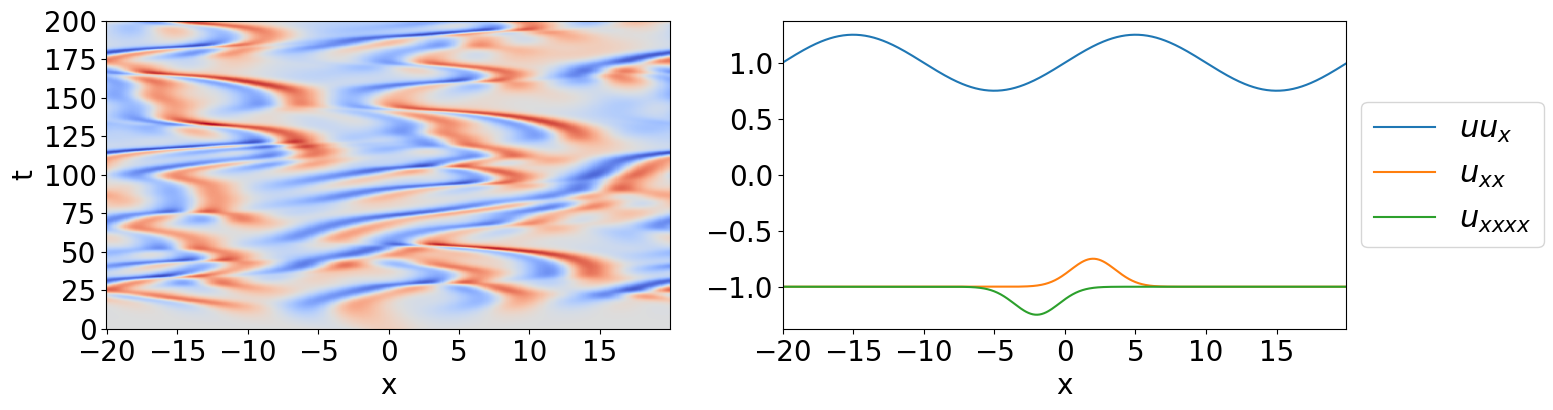

In [4]:
# Plot
fig = figure(figsize=(16, 4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u_full.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

uu_x_true = 1 + 0.25*np.sin(x*2*np.pi/L)
u_xx_true = -1 + 0.25*np.exp(-(x-2)**2/5)
u_4x_true = -1 - 0.25*np.exp(-(x+2)**2/5)

subplot(1,2,2)
plot(x, uu_x_true, label = r'$uu_x$')
plot(x, u_xx_true, label = r'$u_{xx}$')
plot(x, u_4x_true, label = r'$u_{xxxx}$')
xlim([x[0],x[-1]])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
# u = u_full[:,-m:]
# t = t[-m:]
u = u_full[:,:m]
t = t[:m]

In [6]:
noise_lv = 0.01
np.random.seed(0)
u = u + noise_lv*0.01*std(u)*np.random.randn(n,m)

is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=0)

alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=False)

In [7]:
# Theta_grouped = np.array([real(Theta[n*np.arange(m)+j,:]) for j in range(n)])
# Ut_grouped = np.array([real(Ut[n*np.arange(m)+j]) for j in range(n)])
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(Theta_grouped.shape[-1])])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

4 u_xx
5 u_xxx
6 u_xxxx
7 uu_x


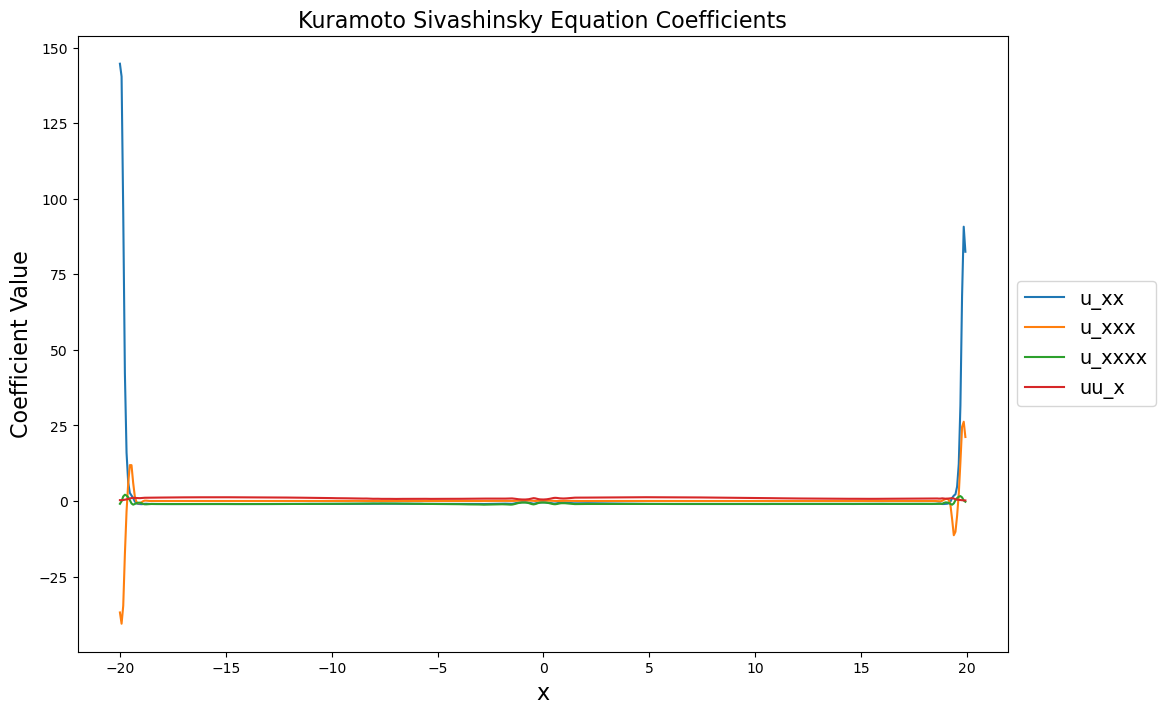

In [9]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.show()
# mse_clean_sgtr = Norm(xi-xi_true[:,wx:-wx])**2/(m*len(rhs_des))
# print('MSE: ', mse_clean_sgtr)

In [10]:
max_complexity = 10
candidates = [[] for _ in range(max_complexity)]
for i in trange(len(Theta_grouped)):
    candidates_i = sorted(set(solvel0(Theta_grouped[i], Ut_grouped[i], max_complexity=max_complexity, 
                                      miosr=True, refine=True, verbose=False)), key=len)
    for i in range(max_complexity):
        candidates[i].append(candidates_i[i])
        
weak_group_sparsity = []
for candidate in candidates:
    k = 0
    unique = Counter([_ for _ in candidate]).keys()
    for _ in unique:
        k += len(_)
    weak_group_sparsity.append(k)
print(weak_group_sparsity)

# candidates   

  0%|                                                                                                         | 0/512 [00:00<?, ?it/s]

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2024-06-04


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [05:06<00:00,  1.67it/s]

[9, 36, 39, 80, 410, 1074, 1764, 2576, 3177, 3570]


In [11]:
group_candidate = []
for candidate in candidates:
    for _ in set(candidate):
        group_candidate.append(_)

lam = 0 # use regtools matlab ดีไหม?
for j in range(len(Ut_grouped)):
    est_xi = Ridge(alpha=0, fit_intercept=False).fit(Theta_grouped[j], Ut_grouped[j]).coef_.reshape(-1, 1)
    difference = Ut_grouped[j] - Theta_grouped[j].dot(est_xi)
    lam += (np.linalg.norm(difference, 2)**2)/(np.linalg.norm(est_xi, 2)**2)
lam /= len(Ut_grouped)
print("lam:", lam)

track = {}
for indices in tqdm(group_candidate):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        ridge_model = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j])
        est_xi = ridge_model.coef_.reshape(-1, 1)
        # difference = Ut_grouped[j] - ridge_model.predict(Theta_grouped[j][:, indices])
        # rss += np.linalg.norm(difference, 2)**2
        difference = fft_Ut_grouped[j] - fft_Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.linalg.norm(difference, 2)**2 + lam*np.linalg.norm(est_xi, 2)**2
        
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss
        
group_candidates = set([e[0] for e in list(track.values())])
group_candidates = sorted(group_candidates, key=len)
group_candidates

lam: 0.4437820097809887


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1605/1605 [12:22<00:00,  2.16it/s]


[(7,),
 (6, 7),
 (4, 6, 7),
 (3, 4, 6, 7),
 (3, 4, 6, 7, 12),
 (1, 3, 4, 6, 7, 8),
 (0, 1, 3, 4, 6, 7, 8),
 (1, 2, 3, 4, 6, 7, 10, 12),
 (1, 3, 4, 6, 7, 8, 9, 10, 12),
 (1, 2, 3, 4, 5, 6, 7, 8, 11, 16)]

6 4


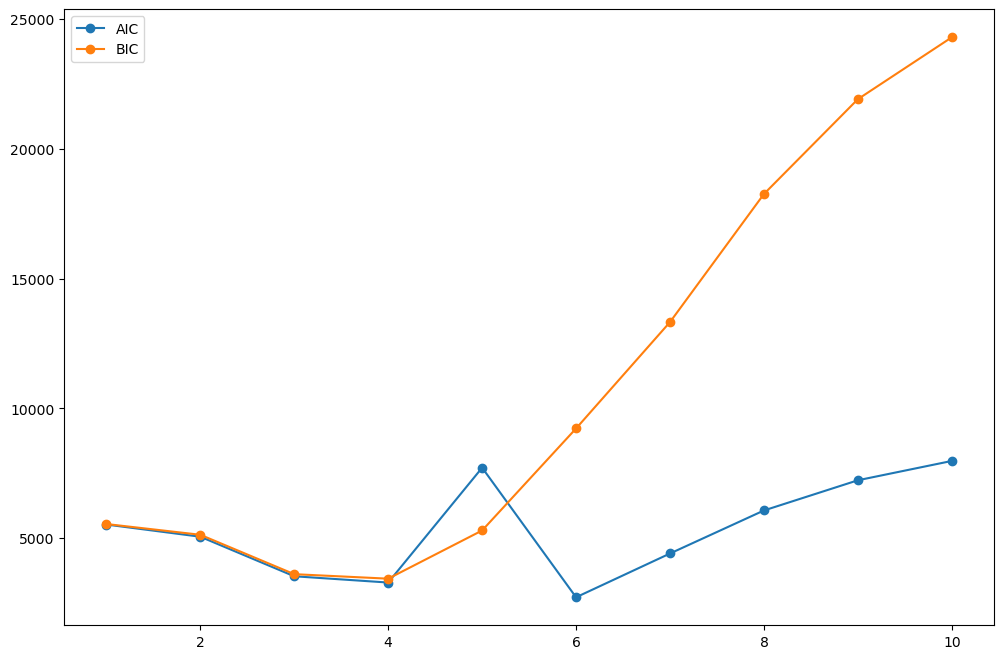

In [12]:
# from scipy import linalg as splinalg
# from scipy.sparse import csc_array, csc_matrix
# from scipy.sparse import linalg as splin

# for indices in sorted(candidates, key=len):
#     theta_b = csc_matrix(splinalg.block_diag(*[Theta_grouped[j][:, indices] for j in range(len(Theta_grouped))]), dtype=float)
#     ut_b = Ut_grouped.reshape(-1, 1)
#     xi_b = splin.lsqr(theta_b, ut_b)[0].reshape(-1, 1)
#     rss = np.sum((ut_b-theta_b@xi_b)**2)
#     print(len(indices), rss2bic(rss, np.count_nonzero(xi_b), len(ut_b)))
#     break

time_integrator = lambda _: _
time_integrator = partial(trapz, axis=1)
time_integrator = compose(partial(trapz, axis=1), 
                          lambda _ : periodogram(_, return_onesided=False, axis=1)[1])
epsilon = 0
ic_scores = {}
ICOMPs = []; a_n = 1
AICs = []
BICs = []
for com, candidate in enumerate(candidates):
    CMs = []
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[candidate[j], j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, candidate[j]], Ut_grouped[j], rcond=None)[0]
        _, CM, _ = llf_complexity(Theta_grouped[j][:, candidate[j]], Ut_grouped[j], a_n=None)
        CMs.append(CM[1])

    k = weak_group_sparsity[com]
    Ut_grouped_est = estimate_Ut_grouped_est(Theta_grouped, est_xi)
    rss = rss_group(Ut_grouped_est, Ut_grouped, time_integrator)
    # N = np.prod(Ut_grouped.shape)
    N = np.prod(time_integrator(Ut_grouped).shape)
    
    # aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    # bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    # aic = N*np.log(2*np.pi*rss/N+epsilon) + 2*k
    aic = N*np.log(2*np.pi*rss/N+epsilon) + 2*k + 2*k+(2*k**2+2*k)/(N-k-1)
    bic = N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k
    icomp = N*np.log(2*np.pi*rss/N+epsilon) + 2*a_n*np.sum(CMs)
    AICs.append(aic)
    BICs.append(bic)
    ICOMPs.append(icomp)

print(np.argmin(AICs)+1, np.argmin(BICs)+1)
plt.plot([_+1 for _ in range(max_complexity)], AICs, '-o', label='AIC')
plt.plot([_+1 for _ in range(max_complexity)], BICs, '-o', label='BIC')
plt.legend()
plt.show()

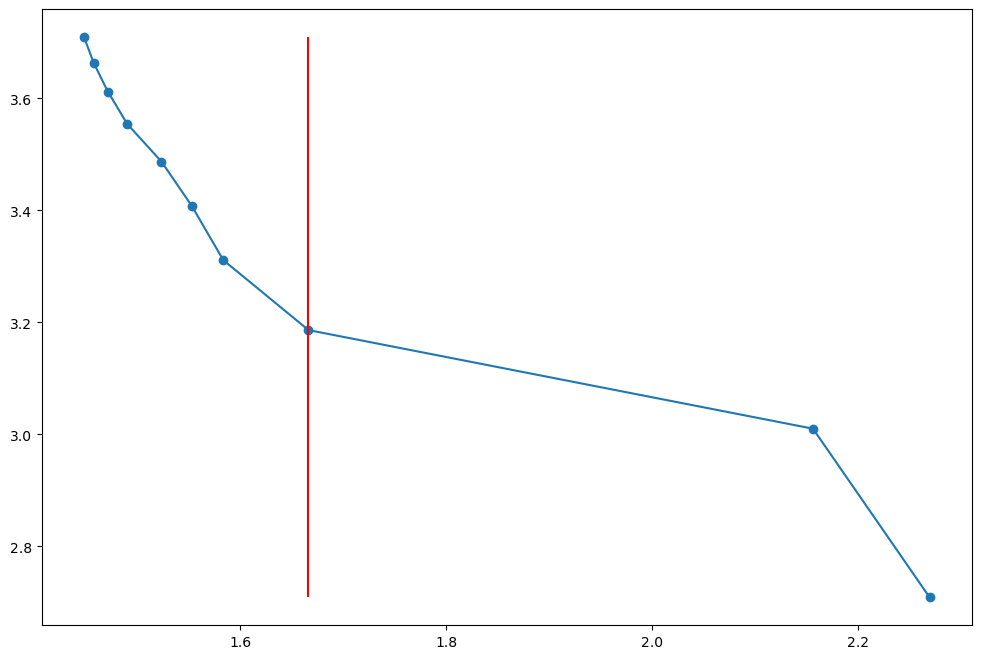

In [13]:
log_errors = []
log_coms = []
for candidate in candidates:
    com = 0
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = SkLinearRegression(fit_intercept=False).fit(Theta_grouped[j][:, candidate[j]], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = Ut_grouped[j] - Theta_grouped[j][:, candidate[j]].dot(est_xi)
        rss += np.sum(difference**2)
        com += np.count_nonzero(est_xi)
    log_error = np.log10(np.sqrt(rss))
    log_com = np.log10(com)
    log_errors.append(log_error)
    log_coms.append(log_com)
plt.plot(log_errors, log_coms, '-o')
plt.vlines(find_corner(log_errors, log_coms, interp_method='polynomial', polynomial_degree=2), 
           ymin=min(log_coms), ymax=max(log_coms), color='red')
plt.show()

## PDE Uncertainty

In [14]:
best_subsets = {}
for com, candidate in enumerate(candidates):
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):
        # model = BayesianRidge(fit_intercept=False)
        model = ARDRegression(fit_intercept=False)
        model.fit(Theta_grouped[j][:, candidate[j]], Ut_grouped[j])
        
        post_prediction = (fft_Theta_grouped[j][:, candidate[j]]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(fft_Ut_grouped[j] - post_prediction)**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    if com+1 not in best_subsets: best_subsets[com+1] = (rss, uncert)
    elif rss < best_subsets[com][0]: best_subsets[com+1] = (rss, uncert)
        
min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
complexities = sorted(best_subsets.keys())
uncertainties = []
for com in complexities:
    _, uncert = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
uncertainties = np.array(uncertainties)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:01<00:00, 490.85it/s]


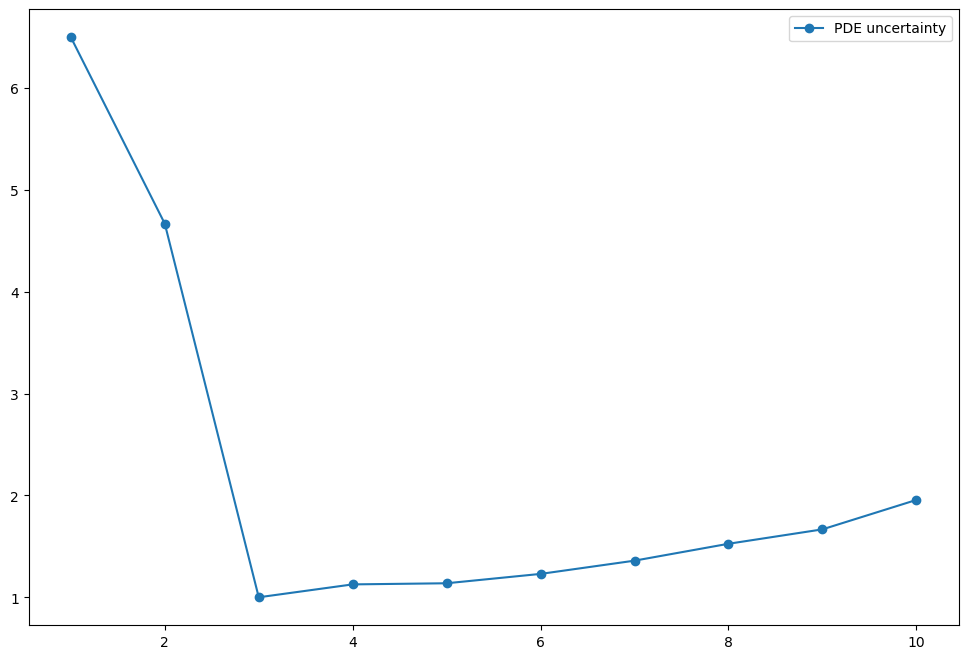

In [15]:
plt.plot([_+1 for _ in range(max_complexity)], uncertainties, '-o', label='PDE uncertainty')
plt.legend()
plt.show()

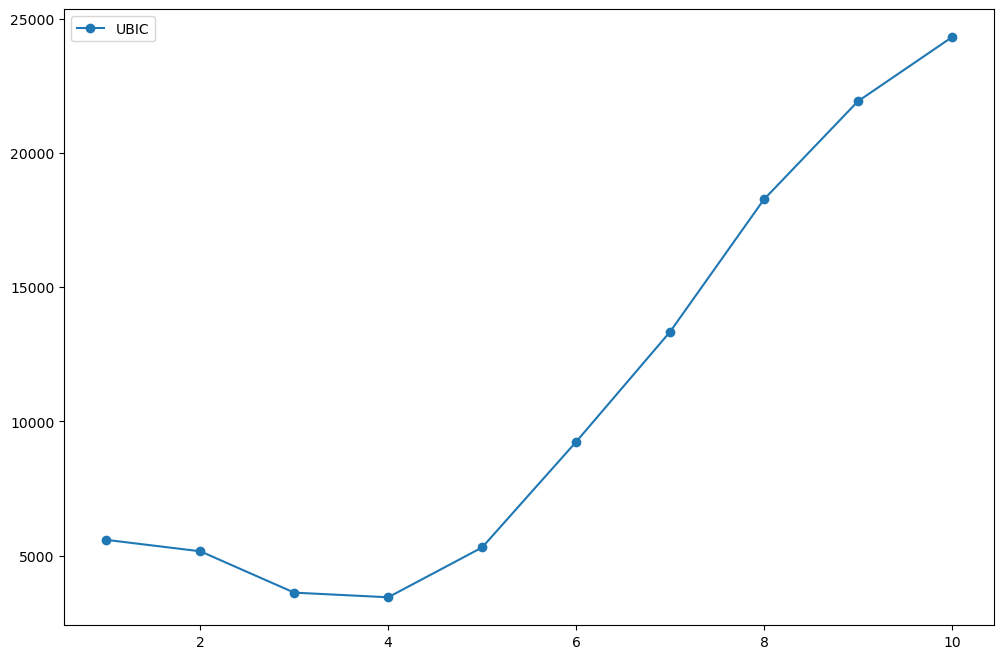

In [16]:
plt.plot([_+1 for _ in range(max_complexity)], np.array(BICs)+np.log(N)*uncertainties, '-o', label='UBIC')
plt.legend()
plt.show()

4 1


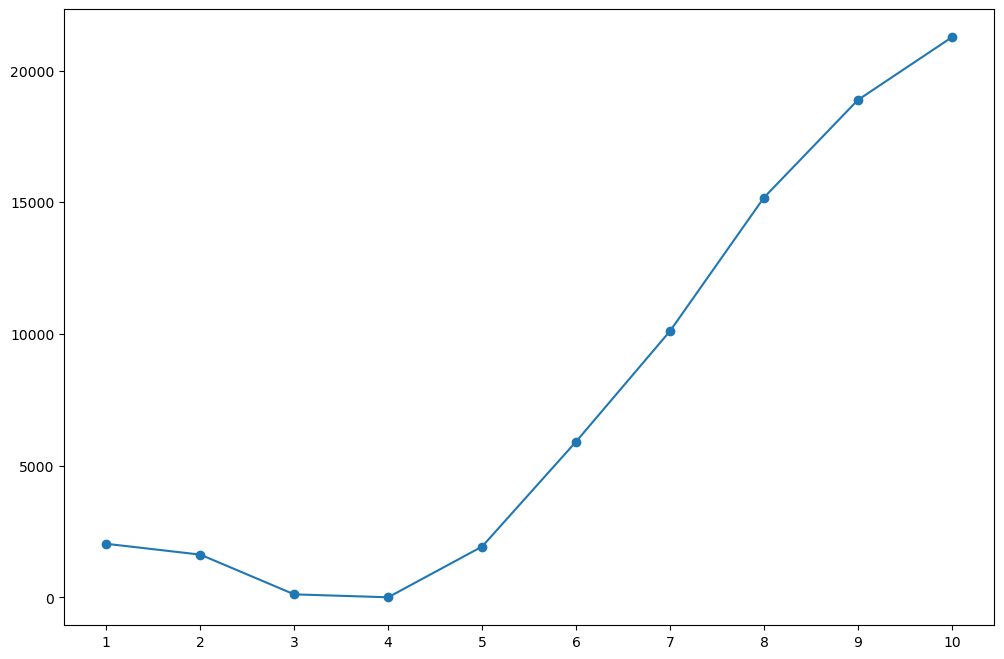

In [17]:
nfft = None; return_onesided = False
# ground_periogram = periodogram(ifft(fft_Ut_grouped[:, :, 0]), nfft=nfft)[-1]
ground_periogram = periodogram(Ut_grouped, axis=1, return_onesided=return_onesided)[1][:, :, 0]

nfft = None
epsilon = 1e-5
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=1) # min_{axis} rss_list
ics = []
rss_list = []
for com, candidate in enumerate(candidates):
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    for j in range(len(Theta_grouped)):
        eff_indices = candidate[j]
#         est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
        est_xi[eff_indices, j:j+1] = ARDRegression(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                                                Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
#         post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
#         post_prediction = periodogram(ifft(post_prediction.flatten()))[-1]
#         ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[-1]
        post_prediction = Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(post_prediction.T, return_onesided=return_onesided)[1]
        ground = periodogram(Ut_grouped[j].T, return_onesided=return_onesided)[1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        vbics.append(rss2bic(rss, com, len(post_prediction), 1e-5))

    # pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    # pred_periogram = periodogram(pred_group, nfft=nfft)[-1]
    pred_group = prediction_group(Theta_grouped, est_xi)
    pred_periogram = periodogram(pred_group, axis=1, return_onesided=return_onesided)[1]
    diff_periogram = time_integrator(ground_periogram)-time_integrator(pred_periogram)
    res = np.vstack([diff_periogram[j] for j in range(len(diff_periogram))])
    nobs = np.prod(diff_periogram.shape)
    rss = np.linalg.norm(res, ord='fro')**2
    ics.append(nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*weak_group_sparsity[com])
    rss_list.append(rss)

print(np.argmin(ics)+1, find_corner(complexities, ics))
plt.plot(complexities, ics-min(ics), '-o')
plt.xticks(complexities)
plt.show()

In [18]:
varying_bics = []
pvalues = []
for _, candidate in enumerate(candidates):
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    for j in range(len(Theta_grouped)):
        eff_indices = candidate[j]
        com = len(eff_indices)
#         est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = ARDRegression(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
#                                                                             Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
        est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
                                                     Ut_grouped[j], 
                                                     rcond=None)[0]
#         post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
#         post_prediction = periodogram(ifft(post_prediction.flatten()))[1]
#         ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[1]
        post_prediction = Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(post_prediction.T, return_onesided=return_onesided)[1]
        ground = periodogram(Ut_grouped[j].T, return_onesided=return_onesided)[1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        # vbics.append(rss2bic(rss, com+uncertainties[com-1], len(post_prediction), epsilon))
        vbics.append(rss2bic(rss, com, len(post_prediction), epsilon))
        
    pvalue = np.nan
    if len(varying_bics) > 0 and not np.allclose(vbics, varying_bics[-1]):
        wres = wilcoxon(vbics, varying_bics[-1], alternative='less')
        pvalue = wres.pvalue
        pvalues.append(pvalue)
    varying_bics.append(vbics)
        
    print(eff_indices, pvalue)

varying_bics = np.array(varying_bics); test_size = varying_bics.shape[1]//2
varying_bics = varying_bics-varying_bics.min()
varying_bics_ranking = np.argsort(varying_bics.sum(axis=-1))
varying_bics = varying_bics[:, sample_without_replacement(varying_bics.shape[1], test_size)]

valid_indices = []
min_bic = np.inf
j = None
pcut = 0.01
pvalues = np.array(pvalues)
pcut = np.median(pvalues[pvalues < pcut])
for i, pvalue in enumerate(pvalues):
    if ics[i] < min_bic:
        min_bic = ics[i]
        if i == 0: pvalue = 0.0
        else: pvalue = wilcoxon(varying_bics[i]-varying_bics[j], alternative='less').pvalue
        if pvalue < pcut:
            valid_indices.append(i)
        j = i
valid_indices

(3,) nan
(3, 7) 6.942546424620457e-86
(6, 7, 10) 8.625765472608506e-86
(6, 7, 8, 10) 8.8357795979982e-22
(6, 7, 8, 10, 15) 5.151190735756129e-19
(6, 7, 8, 10, 11, 14) 0.002824663030781202
(6, 7, 8, 9, 10, 11, 14) 2.3947970445768205e-05
(6, 7, 8, 9, 10, 11, 14, 17) 0.03566437112635655
(0, 6, 7, 8, 9, 10, 11, 14, 17) 0.020490123764895507
(0, 1, 6, 7, 8, 9, 10, 11, 14, 17) 0.12406998669856761


[0, 1, 2]

In [19]:
def conditional_argmin(ics, valid_indices=None):
    am = np.argmin(ics)
    if valid_indices is None:
        return am
    else:
        assert len(valid_indices) > 0 and len(set(valid_indices)-set(np.arange(len(ics)))) == 0
        # return max(valid_indices[np.where(valid_indices<=np.argmin(ics))[0]])
        for idx in np.argsort(ics):
            if idx in valid_indices and idx <= am: return idx
valid_indices = np.array(valid_indices) # None

verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    rss = rss_list[com-1]
    lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-weak_group_sparsity[com-1]
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, weak_group_sparsity[com-1], nobs, epsilon))
assert np.allclose(np.array(ics), np.array(b_bics))
print(find_corner(complexities, b_bics))

idx2lambda =  d = dict([(_-1, []) for _ in complexities])
last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = conditional_argmin(last_ubic, valid_indices)
idx2lambda[np.argmin(last_ubic)].append(last_lam)

thres = 1e-4
percent = 60 # 75 # 90 (เพราะไม่เอา complexity = 1)
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))
print("Threshold:", thres)
print("P-value threshold:", pcut)

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = conditional_argmin(now_ubic, valid_indices)
    idx2lambda[np.argmin(now_ubic)].append(now_lam)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    diff_vbic = (varying_bics[now_bc]-varying_bics[last_bc])
    
    diff_vbic_adj = np.array([-np.inf for _ in range(1000)])
    adj_bc = varying_bics_ranking[varying_bics_ranking<now_bc]
    if len(adj_bc) > 0:
        adj_bc = adj_bc[0]
        diff_adj = now_bc-adj_bc
        diff_vbic_adj = varying_bics[now_bc]-varying_bics[adj_bc]

    imp = np.nan
    pvalue_pos = pvalue_neg = pvalue_adj = np.nan
    if np.abs(diff_com) > 0:
        # imp < thres <--> pvalue > pcut
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    if not np.allclose(diff_vbic, 0.0):
        pvalue_pos = wilcoxon(diff_vbic, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_vbic, alternative='less').pvalue
    if np.abs(diff_adj) > 0:
        pvalue_adj = wilcoxon(diff_vbic_adj, alternative='less').pvalue

    # new version using wilcoxon test
    if verbose:
        print(last_bc, '--->', adj_bc, '--->', now_bc, 'p-value:', 
              np.nan_to_num(pvalue_pos, nan=np.inf), 
              np.nan_to_num(pvalue_neg, nan=np.inf), 
              np.nan_to_num(pvalue_adj, nan=np.inf))
    if (diff_com > 0 and (diff_bic > 0 or pvalue_pos > pcut or pvalue_adj > pcut)) or \
        (diff_com < 0 and diff_bic > 0 and pvalue_pos > pcut and pvalue_neg <= pcut):
        break

    ### old version using threshold ###
    #     if verbose:
    #         print(last_bc, '--->', now_bc, 'imp:', np.nan_to_num(imp, nan=np.inf))
    #     if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
    #         (diff_com < 0 and diff_bic > 0 and imp > thres):
    #         break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)
    
last_lam = abs(round(last_lam, 8))
best_indices = group_candidates[complexities[last_bc]-1]; print(best_indices, "selected")
lam_plot = min(idx2lambda[last_bc])
ubic_plot = UBIC(b_bics, uncertainties, nobs, hyp=10**lam_plot)
lam_plot, last_lam, last_ubic, last_bc

1
Threshold: 0.1179344527741566
P-value threshold: 2.5800132576770633e-19
2 ---> 1 ---> 2 p-value: inf inf 5.817229907487176e-44
2 ---> 1 ---> 2 p-value: inf inf 5.817229907487176e-44
2 ---> 1 ---> 2 p-value: inf inf 5.817229907487176e-44
(4, 6, 7) selected


(2.70219059619708,
 0.0,
 array([ 5588.99336312,  5167.00572712,  3635.20666624,  3525.29947447,
         5451.11390575,  9434.93651043, 13633.28798829, 18702.62944889,
        22409.02562453, 24791.84888821]),
 2)

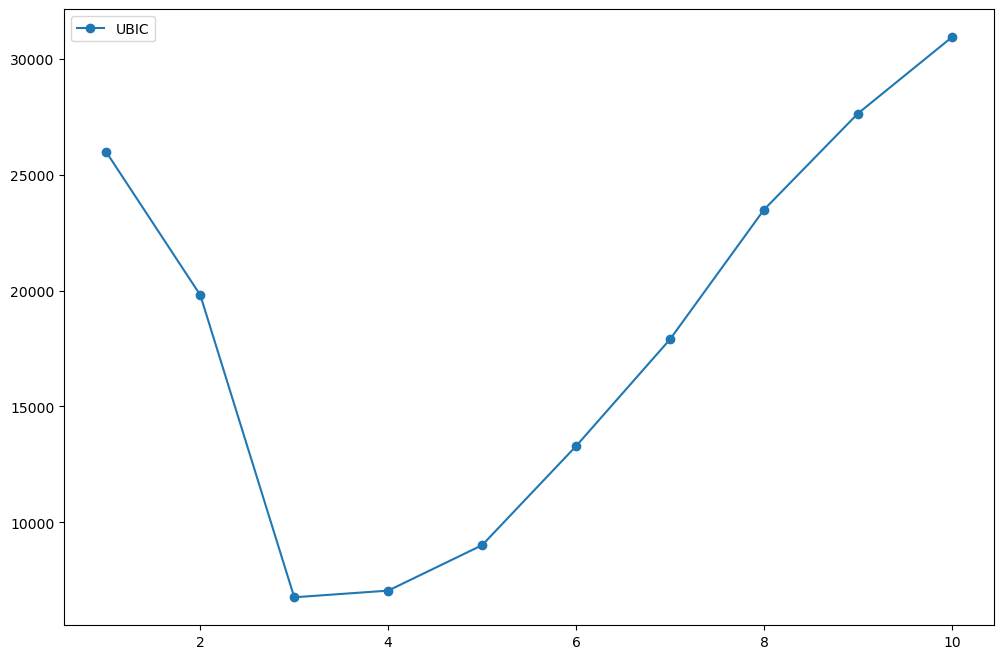

In [20]:
plt.plot([_+1 for _ in range(max_complexity)], ubic_plot, '-o', label='UBIC')
plt.legend()
plt.show()